In [1]:
# This code run the ANOVA on PA parameters providing results for Table 3.
# It can be configure to run the ANOVA on physical fitness, vascular fonction, blood, nutrition variables (Supplementaty Material 3).
# It also tests the distribution of data
#########
# treatment: choose between the 2 below: 
# - intent-to-treat (set ITT==True)
# - per-protocol (set ITT==False)
#########

In [2]:
##############################
import pandas as pd
pd.__version__
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pingouin as pg
from pingouin import pairwise_ttests, read_dataset
from pingouin import corr
##############################
# For diplaying on 90% of your screen widths
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:90% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

C:\Users\BMELAB\Anaconda3\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  % (host, default, e), RuntimeWarning)


## Settings for the main analysis
<p> Please, indicate your settings
</p>

In [3]:
##################################
# Type of analysis
# intent-to-treat?
ITT = False

In [4]:
##################################
# Period of exploration
period = ['0','1','2']
##################################
# all groups or intervention vs. control only?
all_groups = True
##################################
# Posthoc corrections.
correc='holm' # step-down bonferroni, less conservative
##################################
# Pairwise_ttest settings
MARGINAL=True
PARAMETRIC=True
##################################
# which paremeters?
# Uncomment the list of parameters to be used.
param_for_main_analysis = pd.Series(['step-count','PA_(METs / hour)',
                    '30_METs_or_more','40_METs_or_more','50_METs_or_more', '60_METs_or_more',
                    'sedentary', 'light_PA', 'moderate_PA'])
# param_for_main_analysis = pd.Series(['weight', 'waist_circumference','HR','bMAP', 'baPWV',
#                        'glucose','HbA1c','TG_(neutral fat)','tot_cholesterol','trunk_flex','vertical_jump','VO2max_w',
#                                      'energy_intakes','proteins','fat','carb'])

###### Build the path and load data

In [5]:
# path
path = 'C:\\Users\\  \\' #Enter your path
print(path)
data_set = []
data_set.append(pd.read_csv(path+'data_year_0S.csv',index_col=0))
data_set.append(pd.read_csv(path+'data_year_1S.csv',index_col=0))
data_set.append(pd.read_csv(path+'data_year_2S.csv',index_col=0))
print('number of data in year 0 :', data_set[0].shape[0])
print('number of data in year 1 :', data_set[1].shape[0])
print('number of data in year 2 :', data_set[2].shape[0])

C:\Users\BMELAB\Desktop\JUXIS Code\
number of data in year 0 : 574
number of data in year 1 : 512
number of data in year 2 : 469


### Functions for the main ANOVA

In [6]:
def GeneralStats():
    stats_intervention.append(np.mean(da[da['group'] == 'intervention'][of_int]))
    stats_intervention.append(np.std(da[da['group'] == 'intervention'][of_int]))
    stats_intervention.append(len(da[da['group'] == 'intervention'][of_int].dropna()))
    #
    stats_year.append(stats_intervention)
    stats_control.append(np.mean(da[da['group'] == 'control'][of_int]))
    stats_control.append(np.std(da[da['group'] == 'control'][of_int]))
    stats_control.append(len(da[da['group'] == 'control'][of_int].dropna()))    
    #
    stats_year.append(stats_control)
    stats_active.append(np.mean(da[da['group'] == 'active'][of_int]))
    stats_active.append(np.std(da[da['group'] == 'active'][of_int]))
    stats_active.append(len(da[da['group'] == 'active'][of_int].dropna()))
    #
    stats_year.append(stats_active)

    return(stats_year)

In [7]:
def AnovaPlot():
    plt.figure()
    %matplotlib inline
    fig, ax = plt.subplots(1, 2, sharex='row')
    #
    ax[0] = sns.pointplot(x = 'period', y=of_int, hue='group', data=daaa,
                   hue_order= ['intervention','control','active'], ax=ax[0])
    ax[0].set_xticklabels(['baseline', 'year 1', 'year 2'], fontsize=12)
    ax[0].set_title(of_int, fontsize=12)
    ax[1] = sns.pointplot(x = 'period', y=of_int, hue='group', data=daaa,
                   hue_order= ['intervention','control'], ax=ax[1])
    ax[1].set_xticklabels(['baseline', 'year 1', 'year 2'], fontsize=12)
    ax[1].set_title(of_int, fontsize=12)
    #
    plt.show()

    

In [8]:
def AnovaStats(daaa, group):
    if group == True:
        daaa=daaa
    else:
        daaa=daaa[daaa.group != 'active']
    aov = pg.mixed_anova(dv=of_int, within='period', subject='subject_ID', between='group', data=daaa,
                            correction=True)
    # printing of ANOVA summary
    print(of_int,', ANOVA, all_groups =', all_groups, ', ITT =', ITT,  ' :')
    display(aov[['Source','SS','DF1','DF2','MS','F','p-unc','p-GG-corr','np2','eps']])
    if aov['p-unc'].loc[2] < 0.05:
        print('Interaction effect : significant !')
        print('----------------------------------------------')
        print(of_int,'- posthocs :')
        posthocs_group_period = pairwise_ttests(dv=of_int, within=['period'],
                               subject='subject_ID', between=['group','period'],
                               padjust=correc, data=daaa, parametric=PARAMETRIC, marginal=MARGINAL)
        posthocs_period_group = pairwise_ttests(dv=of_int, within=['period'],
                               subject='subject_ID', between=['period','group'],
                               padjust=correc, data=daaa, parametric=PARAMETRIC, marginal=MARGINAL)
        display(posthocs_group_period[((posthocs_group_period.group == 'intervention') | (posthocs_group_period.group == 'control') | (posthocs_group_period.group == 'active'))
                                      & (posthocs_group_period.A == 0)].drop(['Contrast','Paired','p-adjust',
                                                                              #'BF10',
                                                                              'Tail','Parametric'], axis=1).round(3))
        display(posthocs_period_group[((posthocs_period_group.A == 'intervention') | (posthocs_period_group.A == 'control')| (posthocs_period_group.A == 'active'))
                                      & ~(posthocs_period_group.period == '-')].drop(['Contrast','Paired','p-adjust',
                                                                                      #'BF10',
                                                                                      'Tail','Parametric'], axis=1).round(3))

    else:
        print('No interaction')
        print('----------------------------------------------')
        print('No posthoc for', of_int,'or change the statistics parameters and retest')

# ANOVA
<p> QUESTION #1: Is 1-year PA intervention composed of brief counseling sessions and low-dose PA recommendations effective in increasing the level of MVPA in a population of healthy Japanese adults?
<br> QUESTION #2: Are active behaviors possibly adopted during this type of PA intervention still observable 1 year after the end of the intervention?
</p>

step-count , ANOVA, all_groups = True , ITT = False  :


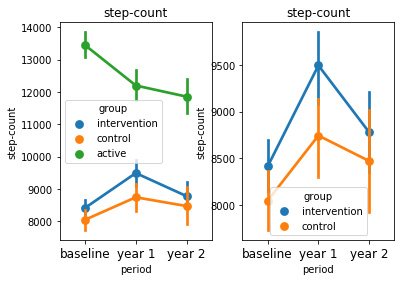

,mean,SD,N,year
intervention,8415.400517,1923.965509,183,0
control,8048.752877,2090.355763,161,0
active,13446.946056,3180.386681,230,0
intervention,9492.811446,2574.667086,166,1
control,8744.225000,2472.375600,132,1
active,12199.395362,3446.373507,211,1
intervention,8779.491608,2743.335479,143,2
control,8472.349167,3035.043061,120,2
active,11855.654500,3941.165596,200,2


general statistics for step-count

---------------------------
step-count , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,5.699823e+09,2,571,2.849912e+09,133.497180,2.718167e-48,NaN,0.318611,NaN
1,period,4.049174e+07,2,1142,2.024587e+07,18.965288,7.894223e-09,0.000001,0.032146,0.952432
2,Interaction,4.062309e+08,4,1142,1.015577e+08,95.134061,6.897954e-70,NaN,0.249936,NaN


Interaction effect : significant !
----------------------------------------------
step-count - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,3.931,427.167,0.000,0.001,169.093,0.375
7,active,0,2,4.552,381.723,0.000,0.000,1993.18,0.446
9,intervention,0,1,-4.380,303.769,0.000,0.000,979.745,-0.475
10,intervention,0,2,-1.344,243.877,0.180,0.720,0.292,-0.156
12,control,0,1,-2.557,257.108,0.011,0.067,2.85,-0.304
13,control,0,2,-1.309,199.327,0.192,0.720,0.299,-0.166


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,19.810,385.582,0.000,0.000,1.209e+58,1.858
7,0,active,control,20.191,387.631,0.000,0.000,6.23e+58,1.930
8,0,intervention,control,1.680,327.414,0.094,0.188,0.461,0.182
9,1,active,intervention,8.702,374.075,0.000,0.000,4.699e+13,0.871
10,1,active,control,10.754,334.484,0.000,0.000,1.611e+20,1.106
11,1,intervention,control,2.540,285.600,0.012,0.035,2.726,0.294
12,2,active,intervention,8.497,340.798,0.000,0.000,8.411e+12,0.876
13,2,active,control,8.581,298.494,0.000,0.000,1.193e+13,0.927
14,2,intervention,control,0.851,242.480,0.396,0.396,0.191,0.106


 
 
PA_(METs / hour) , ANOVA, all_groups = True , ITT = False  :


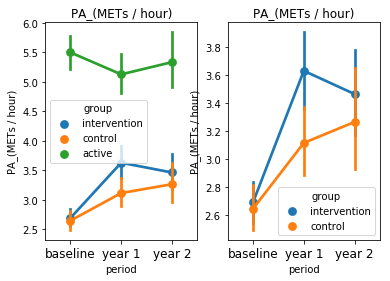

,mean,SD,N,year
intervention,2.693060,1.056826,183,0
control,2.647329,1.012132,161,0
active,5.495739,2.132573,230,0
intervention,3.628313,1.800731,166,1
control,3.115152,1.377332,132,1
active,5.124692,2.570584,211,1
intervention,3.462937,1.773373,143,2
control,3.264167,1.911230,120,2
active,5.331500,3.246484,200,2


general statistics for PA_(METs / hour)

---------------------------
PA_(METs / hour) , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,1842.338777,2,571,921.169388,90.711462,6.161727e-35,NaN,0.241118,NaN
1,period,49.699040,2,1142,24.849520,35.660152,9.491936e-16,2.641189e-13,0.058781,0.906063
2,Interaction,82.241091,4,1142,20.560273,29.504894,2.229305e-23,NaN,0.093665,NaN


Interaction effect : significant !
----------------------------------------------
PA_(METs / hour) - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,1.638,409.240,0.102,0.511,0.386,0.157
7,active,0,2,0.609,335.256,0.543,1.000,0.128,0.060
9,intervention,0,1,-5.824,261.058,0.000,0.000,7.646e+05,-0.638
10,intervention,0,2,-4.578,218.507,0.000,0.000,2202.151,-0.541
12,control,0,1,-3.237,234.857,0.001,0.010,17.934,-0.391
13,control,0,2,-3.203,168.372,0.002,0.010,16.365,-0.418


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,17.383,350.303,0.000,0.000,3.281e+47,1.604
7,0,active,control,17.577,348.599,0.000,0.000,4.963e+47,1.611
8,0,intervention,control,0.408,339.506,0.683,0.776,0.129,0.044
9,1,active,intervention,6.618,370.361,0.000,0.000,6.372e+07,0.658
10,1,active,control,9.375,334.274,0.000,0.000,4.299e+15,0.913
11,1,intervention,control,2.778,295.598,0.006,0.017,4.925,0.314
12,2,active,intervention,6.818,321.453,0.000,0.000,1.831e+08,0.681
13,2,active,control,7.148,317.928,0.000,0.000,1.169e+09,0.729
14,2,intervention,control,0.865,245.545,0.388,0.776,0.194,0.107


 
 
30_METs_or_more , ANOVA, all_groups = True , ITT = False  :


C:\Users\BMELAB\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


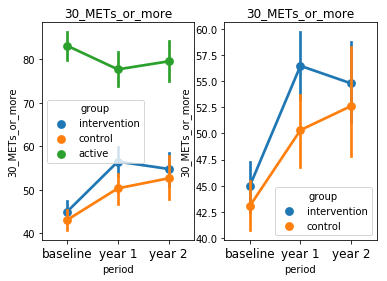

,mean,SD,N,year
intervention,44.958322,16.355078,181,0
control,43.050002,14.820444,158,0
active,83.099372,24.214061,227,0
intervention,56.467470,21.567474,166,1
control,50.322727,20.214863,132,1
active,77.657177,29.565366,211,1
intervention,54.786713,22.834461,143,2
control,52.626667,27.635248,120,2
active,79.507500,33.292612,200,2


general statistics for 30_METs_or_more

---------------------------
30_METs_or_more , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,340060.210028,2,563,170030.105014,113.611337,3.561498e-42,NaN,0.287543,NaN
1,period,7716.682989,2,1126,3858.341494,56.340172,4.786942e-24,2.702525e-19,0.090968,0.946723
2,Interaction,16149.731702,4,1126,4037.432925,58.955297,3.161610e-45,NaN,0.173166,NaN


Interaction effect : significant !
----------------------------------------------
30_METs_or_more - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,2.094,406.589,0.037,0.185,0.878,0.201
7,active,0,2,1.257,358.978,0.210,0.838,0.231,0.124
9,intervention,0,1,-5.547,306.685,0.000,0.000,1.872e+05,-0.602
10,intervention,0,2,-4.328,248.133,0.000,0.000,795.795,-0.502
12,control,0,1,-3.421,235.354,0.001,0.005,31.703,-0.413
13,control,0,2,-3.425,170.400,0.001,0.005,32.416,-0.446


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,18.882,395.947,0.000,0.000,7.078e+53,1.801
7,0,active,control,20.041,377.460,0.000,0.000,7.798e+57,1.910
8,0,intervention,control,1.124,336.510,0.262,0.524,0.22,0.121
9,1,active,intervention,8.020,373.016,0.000,0.000,4.167e+11,0.801
10,1,active,control,10.130,338.205,0.000,0.000,1.236e+18,1.032
11,1,intervention,control,2.522,288.013,0.012,0.037,2.607,0.291
12,2,active,intervention,8.132,340.489,0.000,0.000,7.043e+11,0.837
13,2,active,control,7.764,286.255,0.000,0.000,5.357e+10,0.854
14,2,intervention,control,0.680,230.809,0.497,0.524,0.169,0.085


 
 
40_METs_or_more , ANOVA, all_groups = True , ITT = False  :


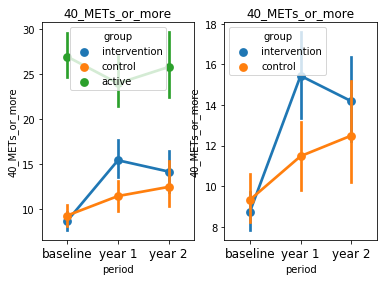

,mean,SD,N,year
intervention,8.732658,6.911774,181,0
control,9.327520,7.856967,158,0
active,26.916909,18.322844,227,0
intervention,15.443373,13.766807,166,1
control,11.481818,9.812475,132,1
active,23.960190,20.015092,211,1
intervention,14.190210,13.418885,143,2
control,12.495000,14.218514,120,2
active,25.771500,25.536189,200,2


general statistics for 40_METs_or_more

---------------------------
40_METs_or_more , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,71020.306829,2,563,35510.153414,56.496218,4.359996e-23,NaN,0.167150,NaN
1,period,1794.941445,2,1126,897.470723,20.264056,2.260013e-09,3.940616e-08,0.034743,0.908611
2,Interaction,4322.217428,4,1126,1080.554357,24.397915,2.180771e-19,NaN,0.079758,NaN


Interaction effect : significant !
----------------------------------------------
40_METs_or_more - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,1.605,424.956,0.109,0.546,0.368,0.154
7,active,0,2,0.525,355.917,0.600,1.000,0.123,0.052
9,intervention,0,1,-5.643,238.392,0.000,0.000,3.033e+05,-0.621
10,intervention,0,2,-4.407,200.724,0.000,0.000,1093.659,-0.527
12,control,0,1,-2.028,249.155,0.044,0.262,0.913,-0.243
13,control,0,2,-2.190,173.417,0.030,0.209,1.284,-0.285


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,13.742,301.870,0.000,0.000,1.368e+32,1.255
7,0,active,control,12.833,328.357,0.000,0.000,1.734e+28,1.172
8,0,intervention,control,-0.733,315.214,0.464,0.652,0.155,-0.080
9,1,active,intervention,4.872,368.836,0.000,0.000,7969.246,0.483
10,1,active,control,7.676,325.530,0.000,0.000,3.557e+10,0.737
11,1,intervention,control,2.886,292.746,0.004,0.013,6.573,0.323
12,2,active,intervention,5.432,316.414,0.000,0.000,1.064e+05,0.540
13,2,active,control,5.952,316.547,0.000,0.000,1.405e+06,0.601
14,2,intervention,control,0.984,247.425,0.326,0.652,0.215,0.122


 
 
50_METs_or_more , ANOVA, all_groups = True , ITT = False  :


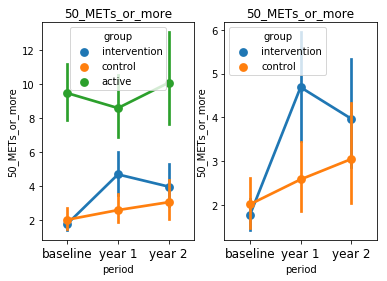

,mean,SD,N,year
intervention,1.767622,2.529436,181,0
control,2.014747,3.840203,158,0
active,9.483182,12.881656,227,0
intervention,4.687349,8.357070,166,1
control,2.584091,4.570605,132,1
active,8.600102,14.100433,211,1
intervention,3.967832,7.603097,143,2
control,3.049167,6.282860,120,2
active,10.095000,19.698426,200,2


general statistics for 50_METs_or_more

---------------------------
50_METs_or_more , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,15439.528331,2,563,7719.764166,27.086261,5.870299e-12,NaN,0.087775,NaN
1,period,543.434270,2,1126,271.717135,11.081830,1.713863e-05,0.000087,0.019304,0.814229
2,Interaction,567.405392,4,1126,141.851348,5.785327,1.309487e-04,NaN,0.020138,NaN


Interaction effect : significant !
----------------------------------------------
50_METs_or_more - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,0.681,424.683,0.496,1.000,0.133,0.065
7,active,0,2,-0.373,335.230,0.709,1.000,0.115,-0.037
9,intervention,0,1,-4.310,192.630,0.000,0.000,742.339,-0.479
10,intervention,0,2,-3.307,166.876,0.001,0.009,21.731,-0.406
12,control,0,1,-1.131,256.515,0.259,1.000,0.238,-0.135
13,control,0,2,-1.586,184.709,0.115,0.802,0.438,-0.204


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,8.794,247.682,0.000,0.000,1.151e+14,0.788
7,0,active,control,8.207,280.905,0.000,0.000,1.557e+12,0.729
8,0,intervention,control,-0.687,265.183,0.493,0.572,0.151,-0.077
9,1,active,intervention,3.343,350.566,0.001,0.004,23.454,0.327
10,1,active,control,5.720,274.229,0.000,0.000,4.457e+05,0.524
11,1,intervention,control,2.755,265.315,0.006,0.019,4.648,0.301
12,2,active,intervention,3.991,274.028,0.000,0.000,219.766,0.385
13,2,active,control,4.665,259.889,0.000,0.000,3188.116,0.437
14,2,intervention,control,1.069,260.949,0.286,0.572,0.233,0.130


 
 
60_METs_or_more , ANOVA, all_groups = True , ITT = False  :


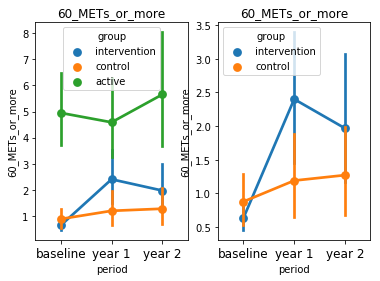

,mean,SD,N,year
intervention,0.634502,1.330283,181,0
control,0.877373,2.469513,158,0
active,4.948053,10.477843,227,0
intervention,2.400602,6.608606,166,1
control,1.190152,3.684300,132,1
active,4.587576,11.728633,211,1
intervention,1.967832,5.802972,143,2
control,1.270833,3.871356,120,2
active,5.655000,16.386851,200,2


general statistics for 60_METs_or_more

---------------------------
60_METs_or_more , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,5089.180095,2,563,2544.590048,13.558590,0.000002,NaN,0.045952,NaN
1,period,234.861952,2,1126,117.430976,6.984511,0.000967,0.00277,0.012254,0.764702
2,Interaction,192.446828,4,1126,48.111707,2.861568,0.022431,NaN,0.010063,NaN


Interaction effect : significant !
----------------------------------------------
60_METs_or_more - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,0.337,421.541,0.736,1.000,0.112,0.032
7,active,0,2,-0.522,330.368,0.602,1.000,0.123,-0.052
9,intervention,0,1,-3.371,177.261,0.001,0.008,26.017,-0.376
10,intervention,0,2,-2.683,153.809,0.008,0.065,3.767,-0.333
12,control,0,1,-0.829,221.637,0.408,1.000,0.18,-0.101
13,control,0,2,-0.969,190.023,0.334,1.000,0.208,-0.124


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,6.127,235.119,0.000,0.000,4.252e+06,0.546
7,0,active,control,5.620,261.184,0.000,0.000,2.844e+05,0.494
8,0,intervention,control,-1.101,233.485,0.272,0.497,0.215,-0.124
9,1,active,intervention,2.280,342.769,0.023,0.093,1.386,0.222
10,1,active,control,3.901,270.829,0.000,0.001,158.931,0.357
11,1,intervention,control,1.995,267.783,0.047,0.141,0.849,0.218
12,2,active,intervention,2.927,263.679,0.004,0.019,7.092,0.281
13,2,active,control,3.609,234.465,0.000,0.002,58.399,0.331
14,2,intervention,control,1.157,249.056,0.248,0.497,0.256,0.138


 
 
sedentary , ANOVA, all_groups = True , ITT = False  :


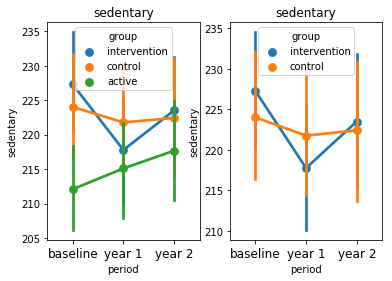

,mean,SD,N,year
intervention,227.295308,47.551734,181,0
control,224.012682,49.219282,158,0
active,212.086041,48.063165,227,0
intervention,217.771084,52.221162,166,1
control,221.769697,46.137031,132,1
active,215.096310,50.984494,211,1
intervention,223.507692,48.584315,143,2
control,222.425000,47.871255,120,2
active,217.672500,51.098003,200,2


general statistics for sedentary

---------------------------
sedentary , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,24305.343580,2,563,12152.671790,1.971586,1.401960e-01,NaN,0.006955,NaN
1,period,2663.566651,2,1126,1331.783326,5.701283,3.438880e-03,0.004193,0.010025,0.989809
2,Interaction,8979.873535,4,1126,2244.968384,9.610573,1.212426e-07,NaN,0.033013,NaN


Interaction effect : significant !
----------------------------------------------
sedentary - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,-0.633,428.509,0.527,1.000,0.129,-0.061
7,active,0,2,-1.156,410.475,0.248,1.000,0.205,-0.112
9,intervention,0,1,1.766,334.176,0.078,0.705,0.528,0.190
10,intervention,0,2,0.701,301.764,0.484,1.000,0.156,0.078
12,control,0,1,0.399,284.137,0.691,1.000,0.14,0.047
13,control,0,2,0.270,259.715,0.788,1.000,0.138,0.032


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,-3.186,387.673,0.002,0.014,14.174,-0.317
7,0,active,control,-2.355,332.530,0.019,0.153,1.632,-0.245
8,0,intervention,control,0.620,327.414,0.535,1.000,0.145,0.068
9,1,active,intervention,-0.498,350.312,0.619,1.000,0.129,-0.052
10,1,active,control,-1.247,298.536,0.213,1.000,0.258,-0.135
11,1,intervention,control,-0.698,292.645,0.485,1.000,0.162,-0.080
12,2,active,intervention,-1.070,314.720,0.285,1.000,0.209,-0.116
13,2,active,control,-0.835,263.304,0.404,1.000,0.177,-0.095
14,2,intervention,control,0.181,254.310,0.857,1.000,0.138,0.022


 
 
light_PA , ANOVA, all_groups = True , ITT = False  :


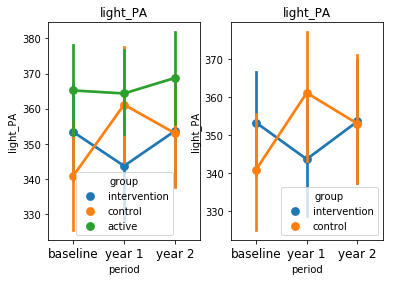

,mean,SD,N,year
intervention,353.325545,96.112485,181,0
control,340.868573,96.576283,158,0
active,365.182792,94.958135,227,0
intervention,343.674699,101.002560,166,1
control,361.142424,98.281471,132,1
active,364.330535,95.207318,211,1
intervention,353.609091,96.434853,143,2
control,353.030833,90.652841,120,2
active,368.745000,98.403201,200,2


general statistics for light_PA

---------------------------
light_PA , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,89922.647636,2,563,44961.323818,1.746917,0.175254,NaN,0.006167,NaN
1,period,7432.766332,2,1126,3716.383166,-25.519595,1.000000,1.0,-0.047480,0.978661
2,Interaction,35601.032886,4,1126,8900.258222,-61.116137,1.000000,NaN,-0.277317,NaN


No interaction
----------------------------------------------
No posthoc for light_PA or change the statistics parameters and retest
 
 
moderate_PA , ANOVA, all_groups = True , ITT = False  :


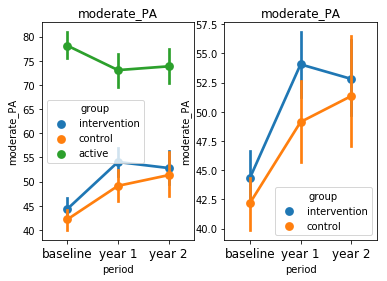

,mean,SD,N,year
intervention,44.323821,15.920036,181,0
control,42.172629,14.326017,158,0
active,78.151319,20.822905,227,0
intervention,54.066867,18.894365,166,1
control,49.132576,19.753260,132,1
active,73.069601,25.229985,211,1
intervention,52.818881,20.626631,143,2
control,51.355833,26.452328,120,2
active,73.852500,25.470883,200,2


general statistics for moderate_PA

---------------------------
moderate_PA , ANOVA, all_groups = True , ITT = False  :


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps
0,group,261965.003692,2,563,130982.501846,115.366550,1.022689e-42,NaN,0.290694,NaN
1,period,5302.928773,2,1126,2651.464386,52.231959,2.029237e-22,1.308356e-17,0.084898,0.955952
2,Interaction,14254.406711,4,1126,3563.601678,70.200413,4.126014e-53,NaN,0.199603,NaN


Interaction effect : significant !
----------------------------------------------
moderate_PA - posthocs :


,group,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,active,0,1,2.284,408.061,0.023,0.114,1.311,0.220
7,active,0,2,1.889,384.795,0.060,0.239,0.601,0.185
9,intervention,0,1,-5.155,323.895,0.000,0.000,2.848e+04,-0.557
10,intervention,0,2,-4.048,261.300,0.000,0.001,271.589,-0.466
12,control,0,1,-3.362,233.665,0.001,0.005,26.306,-0.407
13,control,0,2,-3.425,171.373,0.001,0.005,32.424,-0.446


,period,A,B,T,dof,p-unc,p-corr,BF10,hedges
6,0,active,intervention,18.547,405.338,0.000,0.000,2.504e+52,1.791
7,0,active,control,20.032,382.965,0.000,0.000,7.133e+57,1.943
8,0,intervention,control,1.305,336.672,0.193,0.385,0.272,0.141
9,1,active,intervention,8.337,374.161,0.000,0.000,3.636e+12,0.835
10,1,active,control,9.764,323.988,0.000,0.000,7.732e+16,1.023
11,1,intervention,control,2.176,275.165,0.030,0.091,1.214,0.254
12,2,active,intervention,8.409,335.608,0.000,0.000,4.593e+12,0.888
13,2,active,control,7.441,242.889,0.000,0.000,7.028e+09,0.866
14,2,intervention,control,0.491,222.711,0.624,0.624,0.152,0.062


In [9]:
for of_int in param_for_main_analysis:
    print(of_int,', ANOVA, all_groups =', all_groups, ', ITT =', ITT,  ' :')
    #
    daa = []
    stats = []
    # Build a base
    for year in range(len(period)):
        da = []
        stats_intervention = []
        stats_control = []
        stats_active = []
        stats_year = []
        if year == 0:
            da = []
            da = data_set[year][['subject_ID','group','period',of_int]].dropna()
        else:   
            if ITT == False:
                da = pd.merge(data_set[0][['subject_ID','group']].dropna(),data_set[year][['subject_ID','period',of_int]].dropna(), how='inner', left_on='subject_ID', right_on='subject_ID' )
            if ITT == True:
                da = pd.merge(data_set[0][['subject_ID','group']].dropna(),data_set[year][['subject_ID','period',of_int]], how='left', left_on='subject_ID', right_on='subject_ID' )    
                da[of_int]=da[of_int].fillna(daa[0][of_int])
        daa.append(da)
        # stats
        GeneralStats()
        stats_year= pd.DataFrame(stats_year,
                 index=['intervention','control','active'],
                 columns=['mean','SD','N'])
        stats_year['year']=year
        stats.append(stats_year)
    stats=pd.concat(stats)


    daaa=pd.concat(daa)
    AnovaPlot()
    display(stats)
    print('general statistics for', of_int)
    print('')
    print('---------------------------')
    AnovaStats(daaa,group=all_groups)
    print(' ')
    print(' ')






In [10]:
print('The whole ANOVA analysis has been successfully run')

The whole ANOVA analysis has been successfully run


## Function for testing distributions

In [11]:
def NormalityTest(param_for_main_analysis, period):
    for of_int in param_for_main_analysis:
        print(of_int, ' : ')
        for year in range(len(period)):
            norm_intervention = pg.normality(data_set[year][data_set[year]['group']=='intervention'][of_int])
            norm_control = pg.normality(data_set[year][data_set[year]['group']=='control'][of_int])
            norm_active = pg.normality(data_set[year][data_set[year]['group']=='active'][of_int])
            dis = {'intervention year '+str(year): norm_intervention.loc[of_int], 'control year '+str(year): norm_control.loc[of_int],'active year '+str(year): norm_active.loc[of_int]}
            distrib = pd.DataFrame(data=dis)

            plt.figure()
            %matplotlib inline
            fig, ax = plt.subplots(1, 3, sharey='row')
            # determine min and max for each year in order to plot all graph on the same x axis.
            min_for_dis = min(data_set[year][of_int])
            max_for_dis = max(data_set[year][of_int]) 
            #
            ax[0] = sns.distplot(data_set[year][data_set[year]['group']=='intervention'][of_int], ax=ax[0])
            ax[0].set_title('intervention', fontsize=14)
            ax[0].set_xlim([min_for_dis, max_for_dis])
            ax[1] = sns.distplot(data_set[year][data_set[year]['group']=='control'][of_int],ax=ax[1])
            ax[1].set_title('control', fontsize=14)
            ax[1].set_xlim([min_for_dis, max_for_dis])
            ax[2] = sns.distplot(data_set[year][data_set[year]['group']=='active'][of_int],ax=ax[2])
            ax[2].set_title('active', fontsize=14)
            ax[2].set_xlim([min_for_dis, max_for_dis])

            plt.show()    
            display(distrib)
            print('Normality test for ', of_int, 'at year ', str(year))
            print('')
            print('---------------------------')
        print('')
        print('')

### Testing distributions


step-count  : 


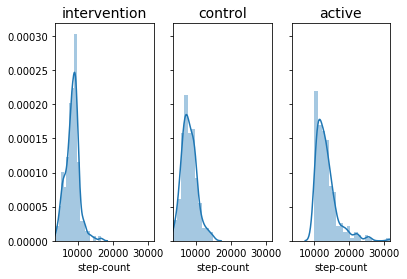

,intervention year 0,control year 0,active year 0
W,0.964608,0.975108,0.80786
pval,0.00013927,0.00526212,3.87584e-16
normal,False,False,False


Normality test for  step-count at year  0

---------------------------


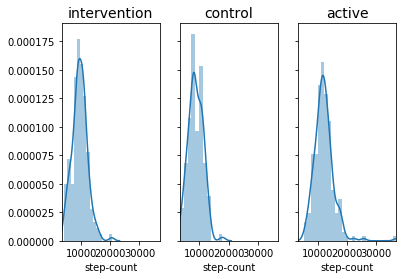

,intervention year 1,control year 1,active year 1
W,0.977293,0.984557,0.869907
pval,0.00791501,0.141419,1.83011e-12
normal,False,True,False


Normality test for  step-count at year  1

---------------------------


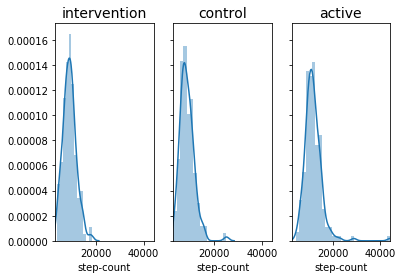

,intervention year 2,control year 2,active year 2
W,0.980547,0.909504,0.783321
pval,0.0396493,6.20924e-07,6.3525e-16
normal,False,False,False


Normality test for  step-count at year  2

---------------------------


PA_(METs / hour)  : 


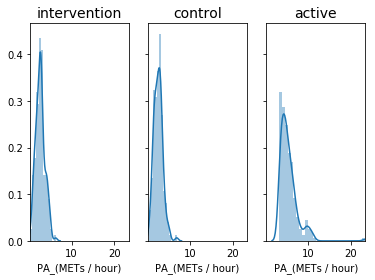

,intervention year 0,control year 0,active year 0
W,0.984052,0.973305,0.759977
pval,0.0352564,0.0032917,5.01356e-18
normal,False,False,False


Normality test for  PA_(METs / hour) at year  0

---------------------------


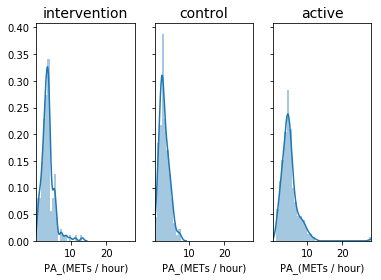

,intervention year 1,control year 1,active year 1
W,0.863643,0.957316,0.761753
pval,4.06479e-11,0.000385057,3.54177e-17
normal,False,False,False


Normality test for  PA_(METs / hour) at year  1

---------------------------


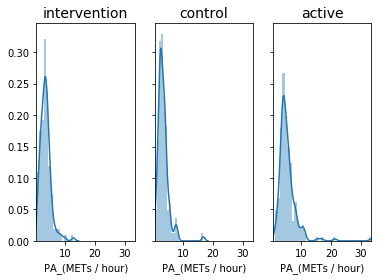

,intervention year 2,control year 2,active year 2
W,0.890085,0.753337,0.668498
pval,7.1037e-09,6.45179e-13,1.40666e-19
normal,False,False,False


Normality test for  PA_(METs / hour) at year  2

---------------------------


30_METs_or_more  : 


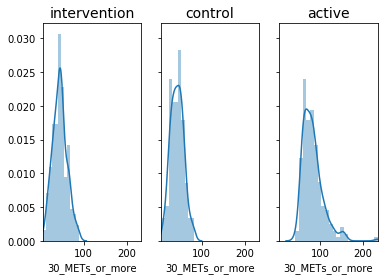

,intervention year 0,control year 0,active year 0
W,0.990753,0.99164,0.870005
pval,0.295264,0.484599,5.34054e-13
normal,True,True,False


Normality test for  30_METs_or_more at year  0

---------------------------


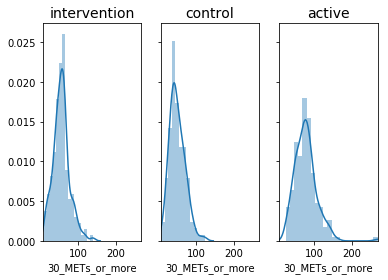

,intervention year 1,control year 1,active year 1
W,0.972406,0.972259,0.915093
pval,0.00213804,0.00835717,1.22075e-09
normal,False,False,False


Normality test for  30_METs_or_more at year  1

---------------------------


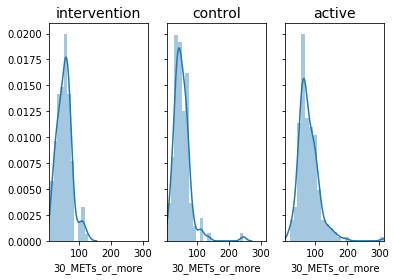

,intervention year 2,control year 2,active year 2
W,0.96778,0.780207,0.851506
pval,0.00189065,4.04523e-12,5.09206e-13
normal,False,False,False


Normality test for  30_METs_or_more at year  2

---------------------------


40_METs_or_more  : 


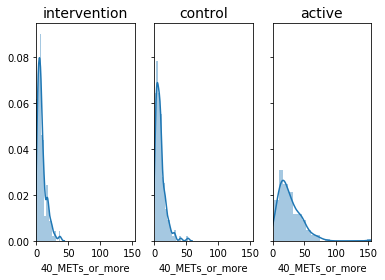

,intervention year 0,control year 0,active year 0
W,0.856888,0.823324,0.863457
pval,4.91539e-12,1.54291e-12,2.32379e-13
normal,False,False,False


Normality test for  40_METs_or_more at year  0

---------------------------


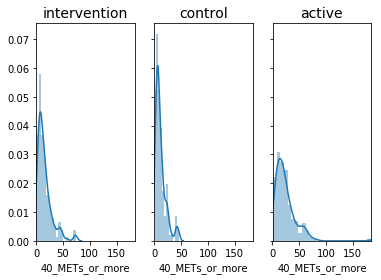

,intervention year 1,control year 1,active year 1
W,0.809609,0.832646,0.779414
pval,1.95074e-13,5.97502e-11,1.56847e-16
normal,False,False,False


Normality test for  40_METs_or_more at year  1

---------------------------


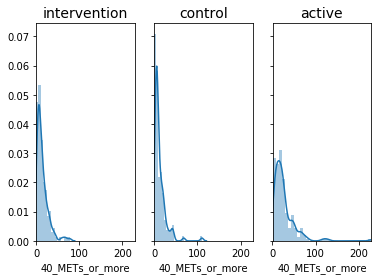

,intervention year 2,control year 2,active year 2
W,0.795048,0.6578,0.702118
pval,7.21522e-13,2.4631e-15,1.2763e-18
normal,False,False,False


Normality test for  40_METs_or_more at year  2

---------------------------


50_METs_or_more  : 


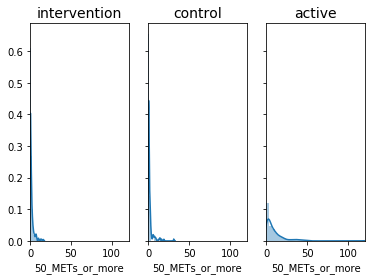

,intervention year 0,control year 0,active year 0
W,0.647247,0.489623,0.65717
pval,3.5238e-19,3.13822e-21,3.73574e-21
normal,False,False,False


Normality test for  50_METs_or_more at year  0

---------------------------


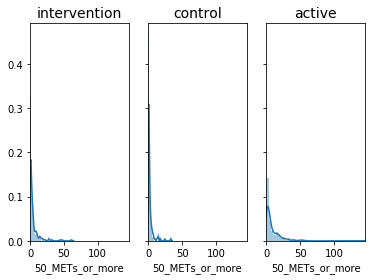

,intervention year 1,control year 1,active year 1
W,0.539801,0.538064,0.558726
pval,9.27577e-21,1.31592e-18,7.75286e-23
normal,False,False,False


Normality test for  50_METs_or_more at year  1

---------------------------


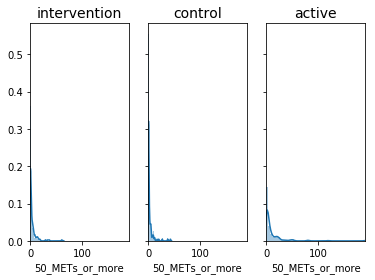

,intervention year 2,control year 2,active year 2
W,0.51393,0.476409,0.486056
pval,8.37155e-20,8.05362e-19,8.89514e-24
normal,False,False,False


Normality test for  50_METs_or_more at year  2

---------------------------


60_METs_or_more  : 


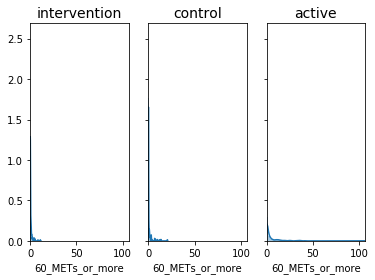

,intervention year 0,control year 0,active year 0
W,0.48676,0.370812,0.486207
pval,1.09539e-22,3.07201e-23,3.39016e-25
normal,False,False,False


Normality test for  60_METs_or_more at year  0

---------------------------


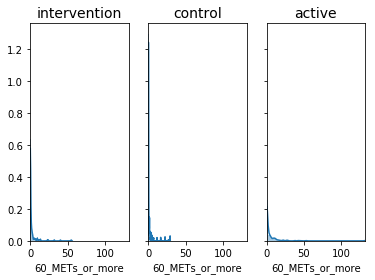

,intervention year 1,control year 1,active year 1
W,0.377919,0.331986,0.388602
pval,1.17186e-23,6.06421e-22,3.49702e-26
normal,False,False,False


Normality test for  60_METs_or_more at year  1

---------------------------


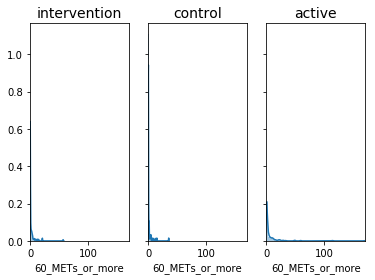

,intervention year 2,control year 2,active year 2
W,0.34816,0.331096,0.341763
pval,1.56269e-22,5.2733e-21,2.43373e-26
normal,False,False,False


Normality test for  60_METs_or_more at year  2

---------------------------


sedentary  : 


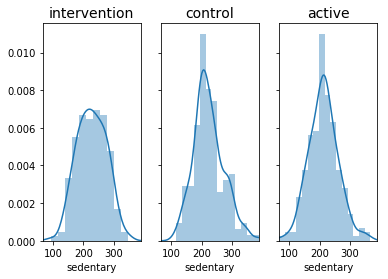

,intervention year 0,control year 0,active year 0
W,0.992295,0.978269,0.993597
pval,0.452027,0.0135511,0.440311
normal,True,False,True


Normality test for  sedentary at year  0

---------------------------


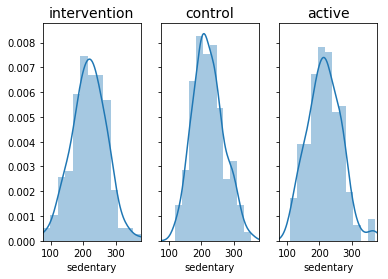

,intervention year 1,control year 1,active year 1
W,0.997225,0.987577,0.985821
pval,0.991299,0.279611,0.0331748
normal,True,True,False


Normality test for  sedentary at year  1

---------------------------


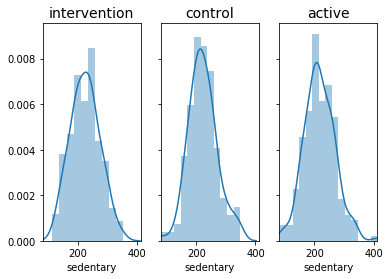

,intervention year 2,control year 2,active year 2
W,0.993118,0.985777,0.989589
pval,0.724042,0.24099,0.155533
normal,True,True,True


Normality test for  sedentary at year  2

---------------------------


light_PA  : 


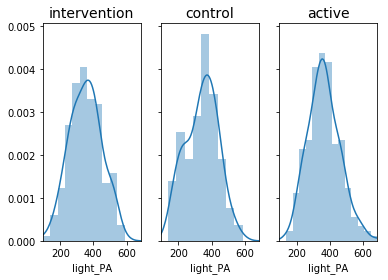

,intervention year 0,control year 0,active year 0
W,0.993901,0.983364,0.990158
pval,0.66074,0.0545023,0.126005
normal,True,True,True


Normality test for  light_PA at year  0

---------------------------


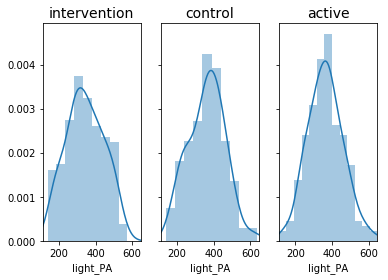

,intervention year 1,control year 1,active year 1
W,0.982709,0.988267,0.99587
pval,0.036589,0.324499,0.84368
normal,False,True,True


Normality test for  light_PA at year  1

---------------------------


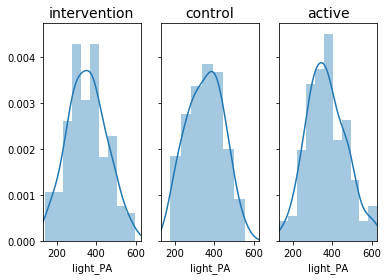

,intervention year 2,control year 2,active year 2
W,0.992871,0.984247,0.988864
pval,0.696792,0.175669,0.121392
normal,True,True,True


Normality test for  light_PA at year  2

---------------------------


moderate_PA  : 


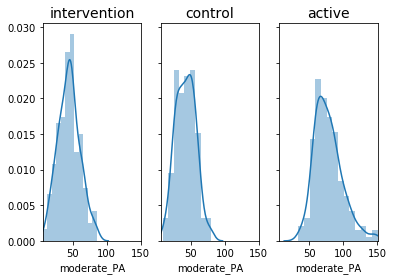

,intervention year 0,control year 0,active year 0
W,0.992067,0.990766,0.95439
pval,0.425718,0.395695,1.32521e-06
normal,True,True,False


Normality test for  moderate_PA at year  0

---------------------------


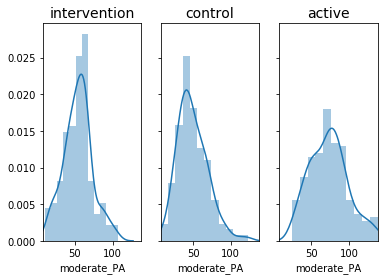

,intervention year 1,control year 1,active year 1
W,0.985451,0.966665,0.980813
pval,0.0810263,0.0025031,0.00563854
normal,True,False,False


Normality test for  moderate_PA at year  1

---------------------------


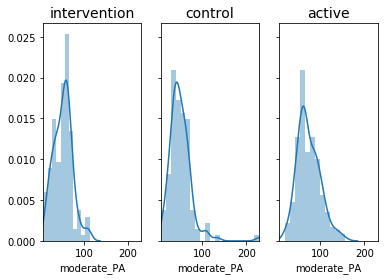

,intervention year 2,control year 2,active year 2
W,0.978029,0.794777,0.973435
pval,0.0211758,1.16838e-11,0.000766491
normal,False,False,False


Normality test for  moderate_PA at year  2

---------------------------




In [12]:
NormalityTest(param_for_main_analysis=param_for_main_analysis, period=period)